In [24]:
%matplotlib inline
import pandas as pd
import seaborn as sns


In [25]:
prosecutors = pd.read_excel("../data/FederalProsecutors.xls")

In [26]:
prosecutors.head()

,First name,Last name,Highest DOJ title,# years DOJ service,Admins served under
0,Dennis,Dimsey,"Deputy Chief, Appellate Section, Civil Rights ...",44.0,"Obama, Bush II, Clinton, Bush I, Reagan, Carte..."
1,Frederick,Hess,"Director Office of Enforcement Operations, Cri...",43.0,"Obama, Bush II, Clinton, Bush I, Reagan, Carte..."
2,Burtis,Dougherty,Senior Trial Attorney,42.0,"Trump, Obama, Bush II, Clinton, Bush I, Reagan..."
3,Hays,Gorey,Trial Attorney,42.0,"Obama, Bush II, Clinton, Bush I, Reagan, Carte..."
4,Richard,Gregorie,"Chief Assistant U.S. Attorney, S.D, FLA.",42.0,"Trump, Obama, Bush II, Clinton, Bush I, Reagan..."


In [27]:
len(prosecutors)

1027

In [28]:
# drop the first row (David W. Mernitz does not have a valid value for years in DOJ service)
prosecutors = prosecutors[1:]

In [29]:
# replace semicolons with commas for seperating admins
prosecutors["Admins served under"] = prosecutors["Admins served under"].str.replace(";",",")

In [30]:
prosecutors.describe()

,# years DOJ service
count,1026.000000
mean,12.459064
std,9.824783
min,1.000000
25%,5.000000
50%,8.000000
75%,18.000000
max,43.000000


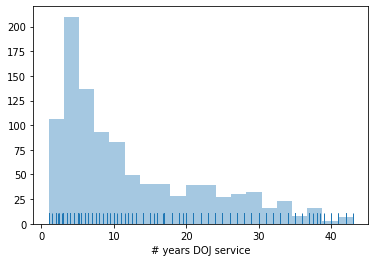

In [31]:
sns.distplot(prosecutors["# years DOJ service"], bins=20, kde=False, rug=True)

In [32]:
prosecutors["# years DOJ service"].mean()

12.45906432748538

In [33]:
prosecutors["# years DOJ service"].median()

8.0

In [34]:
adminDur = {'Trump':2.3,'Obama':8,"Bush II":8,'Clinton':8,'Bush I':4,'Reagan':8,'Carter':4,'Ford':2.34,
           'Nixon':5.6, 'Johnson':5.15, 'Kennedy':2.84, 'Eisenhower':8}

presParty = {'Trump':'R','Obama':'D',"Bush II":'R','Clinton':'D','Bush I':'R','Reagan':'R','Carter':'D','Ford':'R',
           'Nixon':'R', 'Johnson':'D', 'Kennedy':'D', 'Eisenhower':'R'}

# inspired by https://gist.github.com/jlln/338b4b0b55bd6984f883
def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = [admin.strip() for admin in row[target_column].split(separator)]
        number_elem = len(split_row)
        last = split_row[-1:][0]
        for s in split_row:
            admin = s
            new_row = row.to_dict()
            new_row[target_column] = admin
            new_row["approx # years by admin"] = min(adminDur[admin],row["# years DOJ service"]/number_elem)
            new_row["Party when started"] = presParty[last]
            row_accumulator.append(new_row)
        
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    
    new_df = pd.DataFrame(new_rows)
    return new_df

In [35]:
assert adminDur["Obama"] == 8

In [36]:
prosecutorsByAdmin = splitDataFrameList(prosecutors,"Admins served under",",")

In [37]:
prosecutorsByAdmin.astype('object').describe().transpose()

,count,unique,top,freq
First name,2989,482,Robert,132
Last name,2989,905,Chapman,21
Highest DOJ title,2989,616,Assistant U.S. Attorney,266
# years DOJ service,2989,66,5,162
Admins served under,2989,12,Clinton,514
approx # years by admin,2989,99,4,630
Party when started,2989,2,R,1947


In [38]:
prosecutorsByAdmin[0:9]

,First name,Last name,Highest DOJ title,# years DOJ service,Admins served under,approx # years by admin,Party when started
0,Frederick,Hess,"Director Office of Enforcement Operations, Cri...",43.0,Obama,4.777778,D
1,Frederick,Hess,"Director Office of Enforcement Operations, Cri...",43.0,Bush II,4.777778,D
2,Frederick,Hess,"Director Office of Enforcement Operations, Cri...",43.0,Clinton,4.777778,D
3,Frederick,Hess,"Director Office of Enforcement Operations, Cri...",43.0,Bush I,4.000000,D
4,Frederick,Hess,"Director Office of Enforcement Operations, Cri...",43.0,Reagan,4.777778,D
5,Frederick,Hess,"Director Office of Enforcement Operations, Cri...",43.0,Carter,4.000000,D
6,Frederick,Hess,"Director Office of Enforcement Operations, Cri...",43.0,Ford,2.340000,D
7,Frederick,Hess,"Director Office of Enforcement Operations, Cri...",43.0,Nixon,4.777778,D
8,Frederick,Hess,"Director Office of Enforcement Operations, Cri...",43.0,Johnson,4.777778,D


In [39]:
unique_starting_party = prosecutorsByAdmin[["First name","Last name","# years DOJ service","Party when started"]].drop_duplicates()

In [40]:
# checking for 12 unique admins
assert len(prosecutorsByAdmin["Admins served under"].unique()) == 12

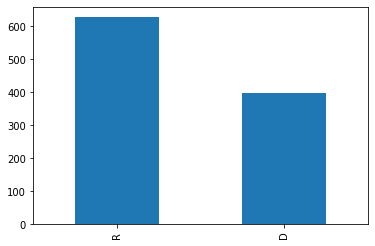

In [41]:
pd.value_counts(unique_starting_party["Party when started"]).plot(kind="bar")

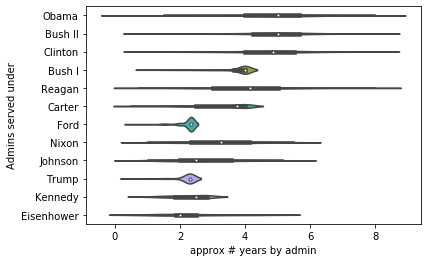

In [42]:
sns.violinplot(y="Admins served under",x="approx # years by admin",data=prosecutorsByAdmin,estimator=sum)
# every dervice longer than 8 years is suspicous: likely data entry error 

In [43]:
prosecutorsByAdmin[prosecutorsByAdmin["approx # years by admin"]>8]

,First name,Last name,Highest DOJ title,# years DOJ service,Admins served under,approx # years by admin,Party when started


In [44]:
prosecutorsByAdmin[prosecutorsByAdmin["# years DOJ service"]<0]

,First name,Last name,Highest DOJ title,# years DOJ service,Admins served under,approx # years by admin,Party when started


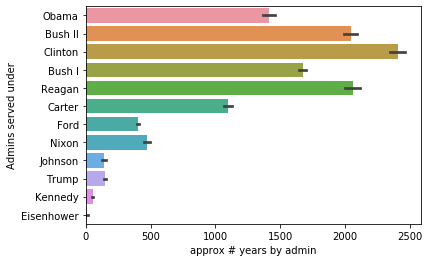

In [45]:
ax = sns.barplot(y="Admins served under",x="approx # years by admin",data=prosecutorsByAdmin,estimator=sum)

In [46]:
prosecutorsByAdmin[prosecutorsByAdmin["Admins served under"]=="Trump"].sort_values(["# years DOJ service"],ascending =  False)

,First name,Last name,Highest DOJ title,# years DOJ service,Admins served under,approx # years by admin,Party when started
9,Burtis,Dougherty,Senior Trial Attorney,42.0,Trump,2.30,R
25,Richard,Gregorie,"Chief Assistant U.S. Attorney, S.D, FLA.",42.0,Trump,2.30,R
42,John,Kolar,Senior Trial Counsel,41.0,Trump,2.30,R
50,Theodore,Merritt,AUSA,41.0,Trump,2.30,D
86,John,Vaudreuil,"Presidentially Appointed US Attorney, Western ...",38.0,Trump,2.30,D
...,...,...,...,...,...,...,...
2941,Michael,Berry,Assistant U.S. Attorney,2.5,Trump,1.25,D
2956,C. Mitchell,Hendy,Assistant US Attorney,2.0,Trump,1.00,D
2964,Ryan,Malone,Assistant United States Attorney,2.0,Trump,1.00,D
2974,Somil,Trivedi,Trial Attorney,1.0,Trump,0.50,D
